# Satellite Data Visualization

**Tutorial Leads:** Carina Poulin (NASA, SSAI), Ian Carroll (NASA, UMBC) and Sean Foley (NASA, MSU)

<div class="alert alert-success" role="alert">

The following notebooks are **prerequisites** for this tutorial:

- [Earthdata Cloud Access](../earthdata_cloud_access)

</div>

## Summary

This is an introductory tutorial to the visualization possibilities arising from PACE data, meant to give you ideas and tools to develop your own scientific data visualizations.

## Learning Objectives

At the end of this notebook you will know:

- How to create an easy global map from OCI data from the cloud
- How to create a true-color image from OCI data processed with OCSSW
- How to make a false color image to look at clouds
- How to make an interactive tool to explore OCI data
- What goes into an animation of multi-angular HARP2 data

## Contents

1. [Setup](#1.-Setup)
2. [Easy Global Chlorophyll-a Map](#2.-Easy-Global-Chlorophyll-a-Map)
3. [Global Oceans in Quasi True Color](#3.-Global-Oceans-in-Quasi-True-Color)
4. [Complete Scene in True Color](#4.-Complete-Scene-in-True-Color)
5. [False Color for Ice Clouds](#5.-False-Color-for-Ice-Clouds)
6. [Phytoplankton in False Color](#6.-Phytoplankton-in-False-Color)
7. [Full Spectra from Global Oceans](#7.-Full-Spectra-from-Global-Oceans)
8. [Animation from Multiple Angles](#8.-Animation-from-Multiple-Angles)

## 1. Setup

Begin by importing all of the packages used in this notebook. If your kernel uses an environment defined following the guidance on the [tutorials] page, then the imports will be successful.

[tutorials]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/

In [13]:
import os

from holoviews.streams import Tap
from matplotlib import animation
from matplotlib.colors import ListedColormap
from PIL import Image, ImageEnhance
from scipy.ndimage import gaussian_filter1d
#from xarray.backends.api import open_datatree
import cartopy.crs as ccrs
import cmocean
import earthaccess
import holoviews as hv
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import panel.widgets as pnw
import xarray as xr

In [ ]:
options = xr.set_options(display_expand_attrs=False)

In this tutorial, we suppress runtime warnings that show up when calculating log for negative values, which is common with our datasets. 

Define a function to apply enhancements, our own plus generic image enhancements from the Pillow package.

In [ ]:
def enhance(rgb, scale = 0.01, vmin = 0.01, vmax = 1.04, gamma=0.95, contrast=1.2, brightness=1.02, sharpness=2, saturation=1.1):
    """The SeaDAS recipe for RGB images from Ocean Color missions.

    Args:
        rgb: a data array with three dimensions, having 3 or 4 bands in the third dimension
        scale: scale value for the log transform
        vmin: minimum pixel value for the image
        vmax: maximum pixel value for the image
        gamma: exponential factor for gamma correction
        contrast: amount of pixel value differentiation 
        brightness: pixel values (intensity)
        sharpness: amount of detail
        saturation: color intensity

    Returns:
       a transformed data array better for RGB display
    """
    rgb = rgb.where(rgb > 0)
    rgb = np.log(rgb / scale) / np.log(1 / scale)
    rgb = rgb.where(rgb >= vmin, vmin)
    rgb = rgb.where(rgb <= vmax, vmax)    
    rgb_min = rgb.min(("number_of_lines", "pixels_per_line"))
    rgb_max = rgb.max(("number_of_lines", "pixels_per_line"))
    rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    rgb = rgb * gamma
    img = rgb * 255
    img = img.where(img.notnull(), 0).astype("uint8")
    img = Image.fromarray(img.data)
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(contrast)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(brightness)
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(sharpness)
    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(saturation)
    rgb[:] = np.array(img) / 255
    return rgb

def enhancel3(rgb, scale = .01, vmin = 0.01, vmax = 1.02, gamma=.95, contrast=1.5, brightness=1.02, sharpness=2, saturation=1.1):
   
    rgb = rgb.where(rgb > 0)
    rgb = np.log(rgb / scale) / np.log(1 / scale)
    rgb = (rgb -  rgb.min()) / (rgb.max() - rgb.min())
    rgb = rgb * gamma
    img = rgb * 255
    img = img.where(img.notnull(), 0).astype("uint8")
    img = Image.fromarray(img.data)
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(contrast)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(brightness)
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(sharpness)
    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(saturation)
    rgb[:] = np.array(img) / 255    
    return rgb

def pcolormesh(rgb):
    fig = plt.figure()
    axes = plt.subplot()
    artist = axes.pcolormesh(
        rgb["longitude"],
        rgb["latitude"],
        rgb,
        shading="nearest",
        rasterized=True,
    )
    axes.set_aspect("equal")

[back to top](#Contents)

## 2. Easy Global Chlorophyll-a Map

Let's start with the most basic visualization. First, get level-3 chlorophyll map product, which is already gridded on latitudes and longitudes. 

In [6]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL_NRT",
    granule_name="*.MO.*.0p1deg.*",
)
paths = earthaccess.open(results)

AttributeError: 'NoneType' object has no attribute 'open'

In [ ]:
dataset = xr.open_dataset(paths[-1])
chla = dataset["chlor_a"]

Now we can already create a global map. Let's use a special colormap from `cmocean` to be fancy, but this is not necessary to make a basic map. Use the `robust="true"` option to remove outliers. 

In [ ]:
artist = chla.plot(cmap=cmocean.cm.algae, robust="true")
plt.gca().set_aspect("equal")

## 3. Global Oceans in Quasi True Color

True color images use three bands to create a RGB image. Let's still use a level-3 mapped product, this time we use the remote-sensing reflectance (Rrs) product. 

In [ ]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS_NRT",
    granule_name="*.MO.*.0p1deg.*",
)
paths = earthaccess.open(results)

The Level-3 Mapped files have no groups and have variables that XArray recognizes as "coordinates":
variables that are named after their only dimension.

In [ ]:
dataset = xr.open_dataset(paths[-1])

Look at all the wavelentghs available!

In [ ]:
dataset["wavelength"].data

For a true color image, choose three wavelengths to represent the "Red", "Green", and "Blue"
channels used to make true color images.

In [ ]:
rrs_rgb = dataset["Rrs"].sel({"wavelength": [645, 555, 368]})
rrs_rgb

It is always a good practice to build meaningful labels into the dataset, and we'll see next
that it can be very useful as we learn to use metadata while creating visualizations.

For this case, we can attach another variable called "channel" and then swap it with
"wavelength" to become the third dimension of the data array. We'll actually use these
values for a choice of `cmap` below, just for fun.

In [ ]:
rrs_rgb["channel"] = ("wavelength", ["Reds", "Greens", "Blues"])
rrs_rgb = rrs_rgb.swap_dims({"wavelength": "channel"})
rrs_rgb

A complicated figure can be assembled fairly easily using the `xarray.Dataset.plot` method,
which draws on the matplotlib package. For Level-3 data, we can specifically use `imshow`
to visualize the RGB image on the `lat` and `lon` coordinates.

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 7), sharex=True)
for i, item in enumerate(rrs_rgb["channel"]):
    array = rrs_rgb.sel({"channel": item})
    array.plot.imshow(x="lon", y="lat", cmap=item.item(), ax=axs[i], robust=True)
    axs[i].set_aspect("equal")
fig.tight_layout()
plt.show()

We use the `enhancel3` function defined at the start of the tutorial to make adjusments to the image. 

In [ ]:
rrs_rgb_enhanced = enhancel3(rrs_rgb)

And we create the image using the `imshow` function. 

In [ ]:
artist = rrs_rgb_enhanced.plot.imshow(x="lon", y="lat")
plt.gca().set_aspect("equal")

Finally, we can add a grid and coastlines to the map with `cartopy` tools. 

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
artist = rrs_rgb_enhanced.plot.imshow(x="lon", y="lat")
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, color="white", linewidth=0.3)
ax.coastlines(color="white", linewidth=1)
plt.show()

[back to top](#Contents)

## 4. Complete Scene in True Color

The best product to create a high-quality true-color image from PACE is the Surface Reflectance (rhos). Cloud-masked rhos are distributed in the SFREFL product suite. If you want to create an image that includes clouds, however, you need to process a Level-1B file to Level-2 using l2gen, like we will show in the OCSSW data processing exercise.

All files created by a PACE Hackweek tutorial can be found in the `/shared/pace-hackweek-2024/` folder accessible from the JupyterLab file browser. In this tutorial, we'll use a Level-2 file created in advance. Note that the JupyterLab file browser treats `/home/jovyan` (that's your home directory, Jovyan) as the root of the browsable file system.

In [ ]:
path = "/home/jovyan/shared/pace-hackweek-2024/PACE_OCI.20240605T092137.L2_SFREFL.V2.nc"
datatree = open_datatree(path)
dataset = xr.merge(datatree.to_dict().values())
dataset

The longitude and latitude variables are geolocation arrays, and while they are spatial
coordinates they cannot be set as an index on the dataset because each array is itself
two-dimensional. The rhos are not on a rectangular grid, but it is still useful to tell
XArray what will become axis labels.

In [ ]:
dataset = dataset.set_coords(("longitude", "latitude"))
dataset

We then select the three wavelenghts that will become the red, green and blue chanels in our image. 

In [ ]:
rhos_rgb = dataset["rhos"].sel({"wavelength_3d": [645, 555, 368]})
rhos_rgb

We are ready to have a look at our image. The most simple adjustment is normalization of the range across the three RGB channels.

In [ ]:
rhos_rgb_max = rhos_rgb.max()
rhos_rgb_min = rhos_rgb.min()
rhos_rgb_enhanced = (rhos_rgb - rhos_rgb_min) / (rhos_rgb_max - rhos_rgb_min)

To visualize these data, we have to use the fairly smart `pcolormesh` artists, which interprets
the geolocation arrays as pixel centers. TODO: why the warning, though?

In [ ]:
pcolormesh(rhos_rgb_enhanced)

Let's have a look at the image's histogram that shows the pixel intensity value distribution across the image. Here, we can see that the values are skewed towards the low intensities, which makes the image dark. 

In [ ]:
rhos_rgb_enhanced.plot.hist()

Another type of enhancement involves a logarithmic transform of the data before normalizing to the unit range.

In [ ]:
rhos_rgb_enhanced = rhos_rgb.where(rhos_rgb > 0, np.nan)
rhos_rgb_enhanced = np.log(rhos_rgb_enhanced / 0.01) / np.log(1 / 0.01)
rhos_rgb_max = rhos_rgb_enhanced.max()
rhos_rgb_min = rhos_rgb_enhanced.min()
rhos_rgb_enhanced = (rhos_rgb_enhanced - rhos_rgb_min) / (rhos_rgb_max - rhos_rgb_min)
pcolormesh(rhos_rgb_enhanced)

Perhaps it is better to do the unit normalization independently for each channel? We can use
XArray's ability to use and align labelled dimensions for the calculation.

In [ ]:
rhos_rgb_max = rhos_rgb.max(("number_of_lines", "pixels_per_line"))
rhos_rgb_min = rhos_rgb.min(("number_of_lines", "pixels_per_line"))
rhos_rgb_enhanced = (rhos_rgb - rhos_rgb_min) / (rhos_rgb_max - rhos_rgb_min)
pcolormesh(rhos_rgb_enhanced)

Let's go back to the log-transformed image, but this time adjust the minimum and maximum pixel values `vmin` and `vmax`. 

In [ ]:
rhos_rgb_enhanced = rhos_rgb.where(rhos_rgb > 0, np.nan)
rhos_rgb_enhanced = np.log(rhos_rgb_enhanced / 0.01) / np.log(1 / 0.01)

In [ ]:
vmin = 0.01
vmax = 1.04

rhos_rgb_enhanced = rhos_rgb_enhanced.where(rhos_rgb_enhanced <= vmax, vmax)
rhos_rgb_enhanced = rhos_rgb_enhanced.where(rhos_rgb_enhanced >= vmin, vmin)

In [ ]:
rhos_rgb_max = rhos_rgb.max(("number_of_lines", "pixels_per_line"))
rhos_rgb_min = rhos_rgb.min(("number_of_lines", "pixels_per_line"))
rhos_rgb_enhanced = (rhos_rgb_enhanced - rhos_rgb_min) / (rhos_rgb_max - rhos_rgb_min)
pcolormesh(rhos_rgb_enhanced)

This image looks much more balanced. The histogram is also going to indicate this:

In [ ]:
rhos_rgb_enhanced.plot.hist()

Everything we've been trying is already built into the `enhance` function, including extra goodies from the Pillow package of generic image processing filters.

In [ ]:
rhos_rgb_enhanced = enhance(rhos_rgb)
pcolormesh(rhos_rgb_enhanced)

Since every image is unique, we can further adjust the parameters. 

In [ ]:
rhos_rgb_enhanced = enhance(rhos_rgb, contrast=1.2, brightness=1.1, saturation=0.8)
pcolormesh(rhos_rgb_enhanced)

[back to top](#Contents)

## 5. False Color for Ice Clouds

We can use the same RGB image method, this time with different bands, to create false-color images that highlight specific elements in an image. 

For example, using a combination of infrared bands can highlight ice clouds in the atmosphere, versus regular water vapor clouds. Let's try it:

In [ ]:
rhos_ice = dataset["rhos"].sel({"wavelength_3d": [1618, 2131, 2258]})

In [ ]:
rhos_ice_enhanced = enhance(rhos_ice, vmin=0, vmax=0.9, scale=.1, gamma =1, contrast=1, brightness=1, saturation=1)
pcolormesh(rhos_ice_enhanced)

Here, the ice clouds are purple and water vapor clouds are white, like we can see in the northwestern region of the scene. 

[back to top](#Contents)

## 6. Phytoplankton in False Color

A uniquely innovative type of product from PACE is the phytoplankton community composition, using the MOANA algorithm. It gives the abundance of three types of plankton: picoeucaryotes, prochlorococcus and synechococcus. These products were used to create the first light image for PACE. Let's see how. 

We first open the dataset that is created with l2gen. This will be covered in the OCSSW tutorial. 

In [ ]:
path = "/home/jovyan/shared/pace-hackweek-2024/PACE_OCI.20240309T115927.L2_MOANA.V2.nc"

datatree = open_datatree(path)
dataset = xr.merge(datatree.to_dict().values())
dataset

We can see the MOANA products, RGB bands and other level-2 products in the dataset. We still need to set the spatial variables as coordinates of the dataset. 

In [ ]:
dataset = dataset.set_coords(("longitude", "latitude"))

Let's make a quick MOANA product plot to see if everything looks normal. 

In [ ]:
artist = dataset["picoeuk_moana"].plot(x="longitude", y="latitude", cmap="viridis", vmin=0, robust="true")
plt.gca().set_aspect("equal")

Now we create a RGB image using our three rhos bands and the usual log-transform, vmin/vmax adjustments and normalization. We also project the map using cartopy. 

In [ ]:
# OCI True Color 1 band -min/max adjusted
vmin = 0.01
vmax = 1.04 # Above 1 because whites can be higher than 1
#---- 

rhos_red = dataset["rhos_645"]
rhos_green = dataset["rhos_555"]
rhos_blue = dataset["rhos_465"]
red = np.log(rhos_red/0.01)/np.log(1/0.01)
green = np.log(rhos_green/0.01)/np.log(1/0.01)
blue = np.log(rhos_blue/0.01)/np.log(1/0.01)
red = red.where((red >= vmin) & (red <= vmax), vmin, vmax)
green = green.where((green >= vmin) & (green <= vmax), vmin, vmax)
blue = blue.where((blue >= vmin) & (blue <= vmax), vmin, vmax)
rgb = np.dstack((red, green, blue))
rgb = (rgb -  np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb)) #normalize

fig = plt.figure(figsize=(5, 5))
axes = fig.add_subplot(projection=ccrs.PlateCarree())
artist = axes.imshow(
    rgb,
    extent=(dataset.longitude.min(), dataset.longitude.max(), dataset.latitude.min(), dataset.latitude.max()),
    origin='lower',
    transform=ccrs.PlateCarree(),
    interpolation='none',
)

We then enhance the image. 

In [ ]:
# Image adjustments: change values from 0 to 2, 1 being unchanged
contrast = 1.72
brightness = 1 
sharpness = 2
saturation = 1.3
gamma = .43
#----

normalized_image = (rgb - rgb.min()) / (rgb.max() - rgb.min())
normalized_image = normalized_image** gamma
normalized_image = (normalized_image* 255).astype(np.uint8)
image_pil = Image.fromarray(normalized_image)
enhancer = ImageEnhance.Contrast(image_pil)
image_enhanced = enhancer.enhance(contrast)  
enhancer = ImageEnhance.Brightness(image_enhanced)
image_enhanced = enhancer.enhance(brightness)  
enhancer = ImageEnhance.Sharpness(image_enhanced)
image_enhanced = enhancer.enhance(sharpness)
enhancer = ImageEnhance.Color(image_enhanced)
image_enhanced = enhancer.enhance(saturation)
enhanced_image_np = np.array(image_enhanced) / 255.0  # Normalize back to [0, 1] range

fig = plt.figure(figsize=(5, 5))
axes = plt.subplot(projection=ccrs.PlateCarree())
extent=(dataset.longitude.min(), dataset.longitude.max(), dataset.latitude.min(), dataset.latitude.max())
artist = axes.imshow(enhanced_image_np, extent=extent, origin='lower', transform=ccrs.PlateCarree(), alpha=1)

We then project the MOANA products on the same grid. We can look at Synechococcus as an example. 

In [ ]:
fig = plt.figure(figsize=(5, 5))
axes = fig.add_subplot(projection=ccrs.PlateCarree())
extent=(dataset.longitude.min(), dataset.longitude.max(), dataset.latitude.min(), dataset.latitude.max())
artist = axes.imshow(dataset["syncoccus_moana"], extent=extent, origin='lower', transform=ccrs.PlateCarree(), interpolation='none', cmap="Reds", vmin=0, vmax=35000, alpha = 1)

To layer the three products on our true-color image, we will add transparency to our colormaps for the three plankton products. Look at the Synechococcus product again.

In [ ]:
cmap_greens = pl.cm.Greens # Get original color map
my_cmap_greens = cmap_greens(np.arange(cmap_greens.N)) 
my_cmap_greens[:,-1] = np.linspace(0, 1, cmap_greens.N) # Set alpha for transparency
my_cmap_greens = ListedColormap(my_cmap_greens) # Create new colormap
cmap_reds = pl.cm.Reds
my_cmap_reds = cmap_reds(np.arange(cmap_reds.N))
my_cmap_reds[:,-1] = np.linspace(0, 1, cmap_reds.N)
my_cmap_reds = ListedColormap(my_cmap_reds)
cmap_blues = pl.cm.Blues
my_cmap_blues = cmap_blues(np.arange(cmap_blues.N))
my_cmap_blues[:,-1] = np.linspace(0, 1, cmap_blues.N)
my_cmap_blues = ListedColormap(my_cmap_blues)

fig = plt.figure(figsize=(5, 5))
axes = fig.add_subplot(projection=ccrs.PlateCarree())
extent=(dataset.longitude.min(), dataset.longitude.max(), dataset.latitude.min(), dataset.latitude.max())
artist = axes.imshow(dataset["syncoccus_moana"], extent=extent, origin='lower', transform=ccrs.PlateCarree(), interpolation='none', cmap=my_cmap_reds, vmin=0, vmax=35000, alpha = 1)

We finally assemble the image using the plankton layers and the true-color base layer. 

In [ ]:
fig = plt.figure(figsize=(7, 7))
axes = plt.subplot(projection=ccrs.PlateCarree())
extent=(dataset.longitude.min(), dataset.longitude.max(), dataset.latitude.min(), dataset.latitude.max())
axes.imshow(enhanced_image_np, extent=extent, origin='lower', transform=ccrs.PlateCarree(), alpha=1)
axes.imshow(dataset["prococcus_moana"], extent=extent, origin='lower', transform=ccrs.PlateCarree(), interpolation='none', cmap=my_cmap_blues, vmin=0, vmax=300000, alpha = .5)
axes.imshow(dataset["syncoccus_moana"], extent=extent, origin='lower', transform=ccrs.PlateCarree(), interpolation='none', cmap=my_cmap_reds, vmin=0, vmax=20000, alpha = .5)
axes.imshow(dataset["picoeuk_moana"], extent=extent, origin='lower', transform=ccrs.PlateCarree(), interpolation='none', cmap=my_cmap_greens, vmin=0, vmax=50000, alpha = .5)
plt.show()

[back to top](#Contents)

## 7. Full Spectra from Global Oceans

<div class="alert alert-warning" role="alert">

This section contains **interactive** plots that require a live Python kernel. Not all the widgets will work
when viewing the notebook; the cells have to be executed and the kernel still running. Download the notebook
and give it a try!

</div>


The holoview library and its bokeh extension allow us to explore datasets interactively.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
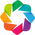

In [4]:
hv.extension("bokeh")

Let's open a level 3 Rrs map. 

In [14]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS_NRT",
    granule_name="*.MO.*.1deg.*",
)

results

[Collection: {'ShortName': 'PACE_OCI_L3M_RRS_NRT', 'Version': '2.0'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180, 'EastBoundingCoordinate': 180, 'NorthBoundingCoordinate': 90, 'SouthBoundingCoordinate': -90}]}}}
 Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-03-31T23:59:59Z', 'BeginningDateTime': '2024-03-01T00:00:00Z'}}
 Size(MB): 7.561065673828125
 Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240301_20240331.L3m.MO.RRS.V2_0.Rrs.1deg.NRT.nc'],
 Collection: {'ShortName': 'PACE_OCI_L3M_RRS_NRT', 'Version': '2.0'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'EastBoundingCoordinate': 180, 'WestBoundingCoordinate': -180, 'SouthBoundingCoordinate': -90, 'NorthBoundingCoordinate': 90}]}}}
 Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-04-30T23:59:59Z', 'BeginningDateTime': '2024-04-01T00:00:00Z'}}
 Size(MB): 7

In [18]:
paths = earthaccess.open(results)

AttributeError: 'NoneType' object has no attribute 'open'

We can create a map from a single band in the dataset and see the Rrs value by hovering over the map. 

In [ ]:
dataset = xr.open_dataset(paths[-1])
def single_band(w):
    array = dataset.sel({"wavelength": w})
    return hv.Image(array, kdims=["lon", "lat"], vdims=["Rrs"]).opts(aspect="equal", frame_width=450, frame_height=250, tools=['hover'])

In [ ]:
single_band(368)

In order to explore the hyperspectral datasets from PACE, we can have a look at the Rrs Spectrum at a certain location. 

In [ ]:
def spectrum(x, y):
    array = dataset.sel({"lon": x, "lat": y}, method="nearest")
    return hv.Curve(array, kdims=["wavelength"]).redim.range(Rrs=(-0.01, 0.04))

In [ ]:
spectrum(0, 0)

Now we can build a truly interactive map with a slider to change the mapped band and a capability to show the spectrum where we click on the map. First, we build the slider and its interactivity with the map:

In [ ]:
slider = pnw.DiscreteSlider(name="wavelength", options=list(dataset["wavelength"].data))
band_dmap = hv.DynamicMap(single_band, streams={"w": slider.param.value})

Then we build the capability to show the Rrs spectrum at the point where we click on the map.

In [ ]:
points = hv.Points([])
tap = Tap(source=points, x=0, y=0)
spectrum_dmap = hv.DynamicMap(spectrum, streams=[tap])

Now try it!

In [ ]:
slider

In [ ]:
(band_dmap * points + spectrum_dmap).opts(shared_axes=False)

[back to top](#Contents)

## 8. Animation from Multiple Angles

Let's look at the multi-angular datasets from HARP2. First, download some HARP2 Level-1C data using the short_name value "PACE_HARP2_L1C_SCI" in earthaccess.search_data. Level-1C corresponds to geolocated imagery. This means the imagery coming from the satellite has been calibrated and assigned to locations on the Earth's surface.


In [ ]:
tspan = ("2024-05-20", "2024-05-20")
results = earthaccess.search_data(
    short_name="PACE_HARP2_L1C_SCI",
    temporal=tspan,
    count=1,
)

In [ ]:
paths = earthaccess.open(results)

In [ ]:
prod = xr.open_dataset(paths[0])
view = xr.open_dataset(paths[0], group="sensor_views_bands").squeeze()
geo = xr.open_dataset(paths[0], group="geolocation_data").set_coords(["longitude", "latitude"])
obs = xr.open_dataset(paths[0], group="observation_data").squeeze()

The `prod` dataset, as usual for OB.DAAC products, contains attributes but no variables. Merge it with the "observation_data" and "geolocation_data", setting latitude and longitude as auxiliary (e.e. non-index) coordinates, to get started.

In [ ]:
dataset = xr.merge((prod, obs, geo))
dataset

### Understanding Multi-Angle Data

HARP2 is a multi-spectral sensor, like OCI, with 4 spectral bands. These roughly correspond to green, red, near infrared (NIR), and blue (in that order). HARP2 is also multi-angle. These angles are with respect to the satellite track. Essentially, HARP2 is always looking ahead, looking behind, and everywhere in between. The number of angles varies per sensor. The red band has 60 angles, while the green, blue, and NIR bands each have 10.

In the HARP2 data, the angles and the spectral bands are combined into one axis. I'll refer to this combined axis as HARP2's "channels." Below, we'll make a quick plot both the viewing angles and the wavelengths of HARP2's channels. In both plots, the x-axis is simply the channel index.

Pull out the view angles and wavelengths.

In [ ]:
angles = view["sensor_view_angle"]
wavelengths = view["intensity_wavelength"]

### Radiance to Reflectance

We can convert radiance into reflectance. For a more in-depth explanation, see [here](https://seadas.gsfc.nasa.gov/help-9.0.0/rad2refl/Rad2ReflAlgorithmSpecification.html#:~:text=Radiance%20is%20the%20variable%20directly,it%2C%20and%20it%20is%20dimensionless). This conversion compensates for the differences in appearance due to the viewing angle and sun angle. Write the conversion as a function, because you may need to repeat it.

In [ ]:
def rad_to_refl(rad, f0, sza, r):
    """Convert radiance to reflectance.
    
    Args:
        rad: Radiance.
        f0: Solar irradiance.
        sza: Solar zenith angle.
        r: Sun-Earth distance (in AU).

    Returns: Reflectance.
    """
    return (r**2) * np.pi * rad / np.cos(sza * np.pi / 180) / f0

The difference in appearance (after matplotlib automatically normalizes the data) is negligible, but the difference in the physical meaning of the array values is quite important.

In [ ]:
refl = rad_to_refl(
    rad=dataset["i"],
    f0=view["intensity_f0"],
    sza=dataset["solar_zenith_angle"],
    r=float(dataset.attrs["sun_earth_distance"]),
)

### Animating an Overpass

<div class="alert alert-warning" role="alert">

WARNING: there is some flickering in the animation displayed in this section.

</div>

All that is great for looking at a single angle at a time, but it doesn't capture the multi-angle nature of the instrument. Multi-angle data innately captures information about 3D structure. To get a sense of that, we'll make an animation of the scene with the 60 viewing angles available for the red band.

We are going to generate this animation without using the latitude and longitude coordinates. If you use XArray's `plot` as above with coordinates, you could use a projection. However, that can be a little slow for all animation "frames" available with HARP2. This means there will be some stripes of what seems like missing data at certain angles. These stripes actually result from the gridding of the multi-angle data, and are not a bug.

Get the reflectances of just the red channel, and normalize the reflectance to lie between 0 and 1.

In [ ]:
refl_red = refl[..., 10:70]
refl_pretty = (refl_red - refl_red.min()) / (refl_red.max() - refl_red.min())

A very mild Gaussian filter over the angular axis will improve the animation's smoothness.

In [ ]:
refl_pretty.data = gaussian_filter1d(refl_pretty, sigma=0.5, truncate=2, axis=2)

Raising the image to the power 2/3 will brighten it a little bit.

In [ ]:
refl_pretty = refl_pretty ** (2 / 3)

Append all but the first and last frame in reverse order, to get a 'bounce' effect.

In [ ]:
frames = np.arange(refl_pretty.sizes["number_of_views"])
frames = np.concatenate((frames, frames[-1::-1]))
frames

In order to display an animation in a Jupyter notebook, the "backend" for matplotlib has to be explicitly set to "widget".

Now we can use `matplotlib.animation` to create an initial plot, define a function to update that plot for each new frame, and show the resulting animation. When we create the inital plot, we get back the object called `im` below. This object is an instance of `matplotlib.artist.Artist` and is responsible for rendering data on the axes. Our `update` function uses that artist's `set_data` method to leave everything in the plot the same other than the data used to make the image.

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(refl_pretty[{"number_of_views": 0}], cmap="gray")

def update(i):
    im.set_data(refl_pretty[{"number_of_views": i}])
    return im

an = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=30)
filename = f'harp2_red_anim_{dataset.attrs["product_name"].split(".")[1]}.gif'
an.save(filename, writer="pillow")
plt.close()

This scene is a great example of multi-layer clouds. You can use the parallax effect to distinguish between these layers.

The [sunglint](https://en.wikipedia.org/wiki/Sunglint) is an obvious feature, but you can also make out the [opposition effect](https://en.wikipedia.org/wiki/Opposition_surge) on some of the clouds in the scene. These details would be far harder to identify without multiple angles!

![A multi-angle HARP2 animation](../../img/harp2_red_anim_20240519T235950.gif)

Notice the cell ends with `plt.close()` rather than the usual `plt.show()`. By default, `matplotlib` will not display an animation. To view the animation, we saved it as a file and displayed the result in the next cell. Alternatively, you could change the default by executing `%matplotlib widget`. The `widget` setting, which works in Jupyter Lab but not on a static website, you can use `plt.show()` as well as `an.pause()` and `an.resume()`.

[back to top](#Contents)